# SVC Nested Cross-Validation 

Here I will attempt to implement a nested cross-validation scheme in order to optimise a Support Vector Classification model via performing model selection and hyperparameter tuning simulatenously. 

## 1. Loading Data

In [1]:
# Importing general packagaes 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading data
data_path = r"glass.xlsx"
glass_data = pd.read_excel(data_path)

In [5]:
print(glass_data.head())

   id       ri  Sodium  Magnesium  Aluminium  Silicon  Potassium  Calcium  \
0   1  1.52101   13.64       4.49       1.10    71.78       0.06     8.75   
1   2  1.51761   13.89       3.60       1.36    72.73       0.48     7.83   
2   3  1.51618   13.53       3.55       1.54    72.99       0.39     7.78   
3   4  1.51766   13.21       3.69       1.29    72.61       0.57     8.22   
4   5  1.51742   13.27       3.62       1.24    73.08       0.55     8.07   

   Barium  Iron  Glass Type  
0     0.0   0.0           1  
1     0.0   0.0           1  
2     0.0   0.0           1  
3     0.0   0.0           1  
4     0.0   0.0           1  


In [7]:
label = "Glass Type"
# Leaving out ID as this obviously doesn't provide any useful information regarding the glass
features_to_use = ['ri', 'Sodium', 'Magnesium', 'Aluminium', 'Silicon', 'Potassium', 'Calcium', 'Barium', 'Iron']

data = glass_data[features_to_use]
label = glass_data[label]

print(data.head())

        ri  Sodium  Magnesium  Aluminium  Silicon  Potassium  Calcium  Barium  \
0  1.52101   13.64       4.49       1.10    71.78       0.06     8.75     0.0   
1  1.51761   13.89       3.60       1.36    72.73       0.48     7.83     0.0   
2  1.51618   13.53       3.55       1.54    72.99       0.39     7.78     0.0   
3  1.51766   13.21       3.69       1.29    72.61       0.57     8.22     0.0   
4  1.51742   13.27       3.62       1.24    73.08       0.55     8.07     0.0   

   Iron  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  


## 2. Assessing Deafualt SVC Performance 

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statistics import mean

# Defining SVC and leaving all parameters as default values 
# C = 1.0, kernel = 'rbf', degree = 3, gamma = 'scale'
svc = SVC()
# 8-Fold Cross-Validation avg. scores
scores = cross_val_score(svc, data, label, cv=8)
print("Default SVC average accuracy performance: ", mean(scores))

Default SVC average accuracy performance:  0.3554131054131054


In [35]:
# Function which plots a clear and easy to read confusion matrix
def confusionMatrixPlot(cm, labels):
    # Useful statistics
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    # Plot
    plt.figure(figsize=(32, 24))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.colorbar()
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label \n Accuracy = {:0.4f}; Misclass = {:0.4f}.'.format(accuracy, misclass))
    plt.show()

In [36]:
cm = confusion_matrix(y_test, yhat)
labels = list(y_test.unique())
labels.sort

<function list.sort(*, key=None, reverse=False)>

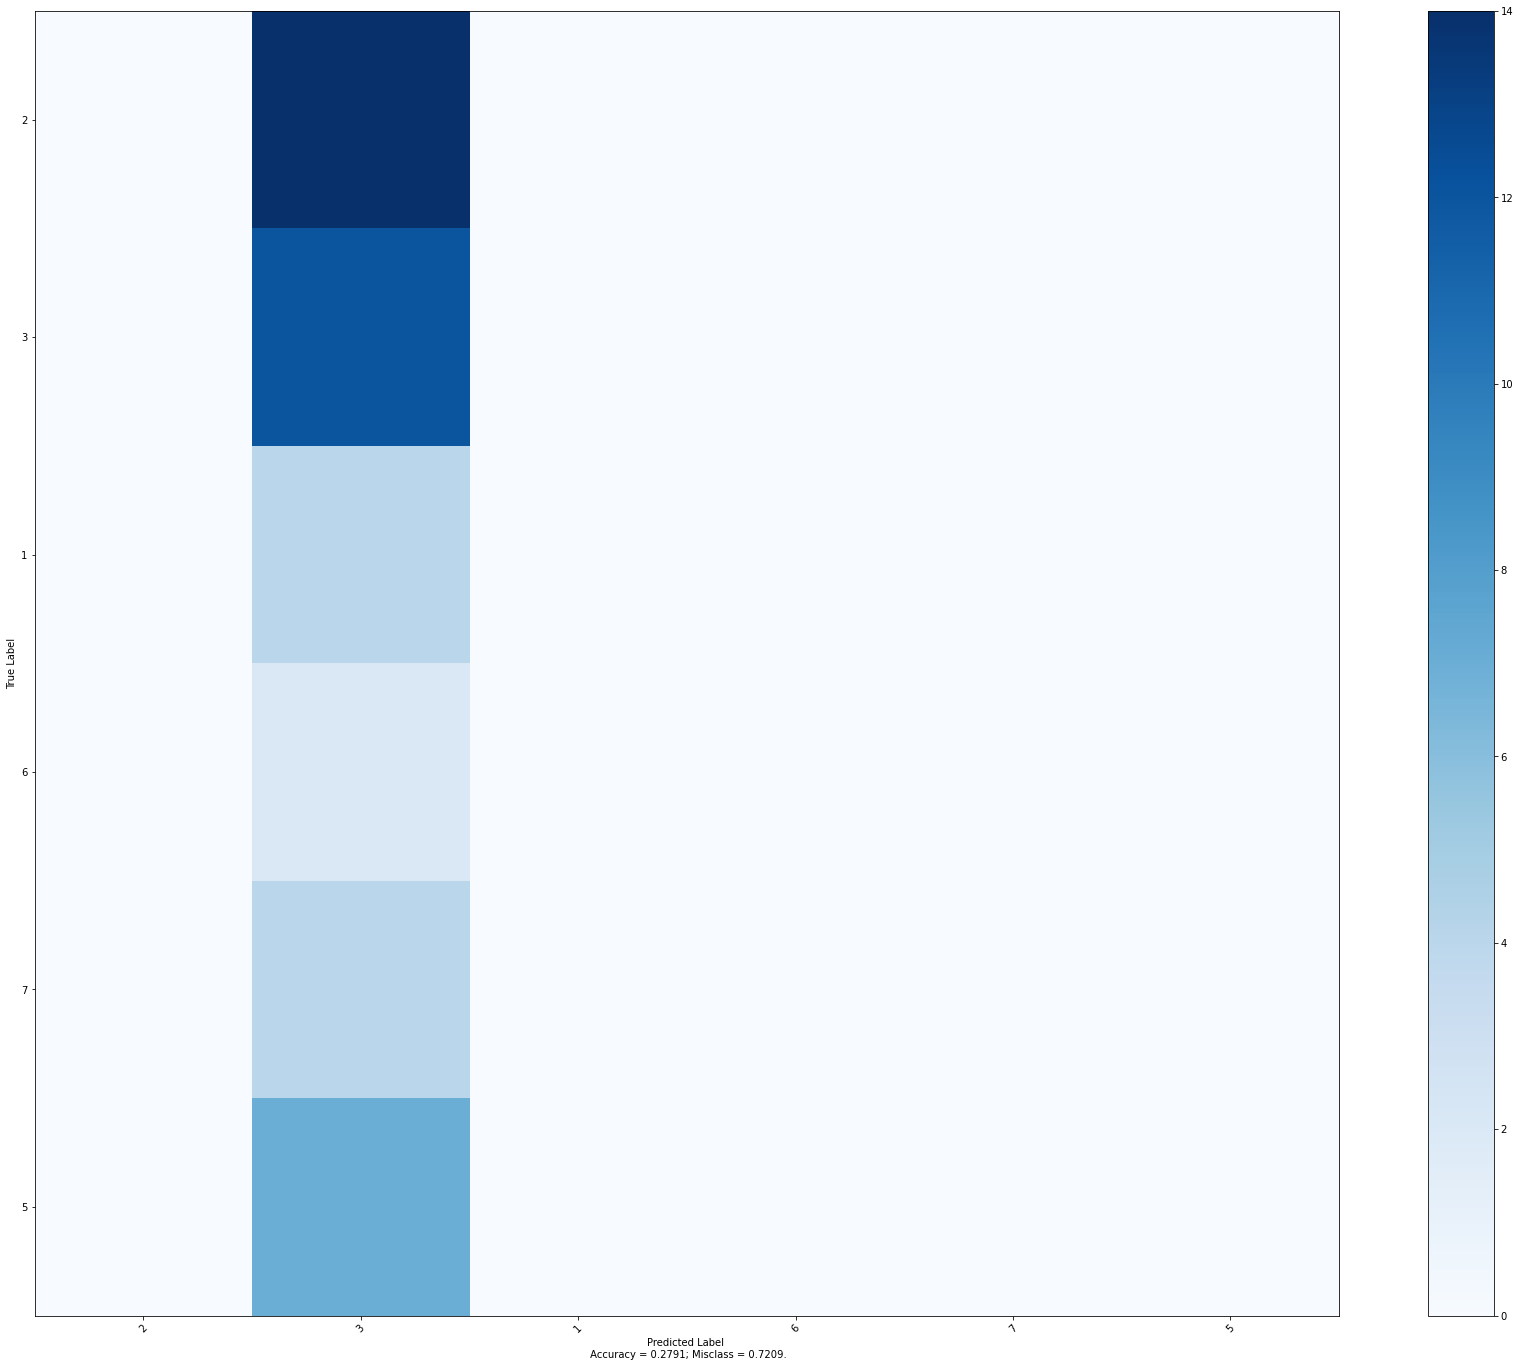

In [37]:
confusionMatrixPlot(cm, labels)

As can be seen from the above confusion matrix, as well as the poor average accuracy score, the default SVC model performs particularly poorly, and seemingly classifies every input into one class (2nd class). This is a consequence of the model's hyperparameters not being fine tuned. Considering this, it is seemingly rational to predict that finding the optimal hyperparameters for a SVC model being fitted to this data-set will exhibit a increase in classification performance.    

## 3. Nested Cross-Validation Evaluation

Nested Cross-Validation (NCV) is a scheme which combines the optimisation of fine-tuning a model's parameters with the standard cross-validation of a model, which evaluates the model's performance on a data-set through training and testing.  

In [62]:
def svc_optimal_params(X_train, y_train):
    # Defining model and parameters
    svc = SVC()
    parameter_grid = [
        {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
        {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [1e-3, 1e-4]}
    ]
    
    # Defining the grid search cross-val algorithm used to find optimal parameter
    # for given iteration 
    nested_folds = KFold(n_splits=5)
    grid_search = GridSearchCV(svc, parameter_grid, scoring='accuracy', cv=nested_folds)
    
    # Execute grid search and return best parameters for given iteration 
    grid_search_output = grid_search.fit(X_train, y_train)
    best_parameters = grid_search_output.best_params_
    return best_parameters

In [63]:
# Testing the optimal parameter output
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)
best_parameters = svc_optimal_params(X_train, y_train)
best_parameters

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [82]:
def svc_nested_cross_val(data, labels):
    # Empty list to record accuracy score after each fold 
    scores = []
    # Model performance folds - shuffle data to prevent ordering (imbalance)  
    outer_folds = KFold(n_splits=9, shuffle=True, random_state=1)
    for train_index, test_index in outer_folds.split(data):
        # Splitting the data for cross validation
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        
        # Retrieve optimal parameter for iteration
        opt_params = svc_optimal_params(X_train, y_train)
        
        # Define SVC model with optimal parameters for given iteratrion
        if 'gamma' in list(opt_params.keys()):
            svc = SVC(C=opt_params['C'], kernel=opt_params['kernel'], gamma=opt_params['gamma'])
        else:
            svc = SVC(C=opt_params['C'], kernel=opt_params['kernel'])
            
        # Fit optimal SVC to training data
        svc.fit(X_train, y_train)
        
        # Calaculate performance
        yhat = svc.predict(X_test)
        score = accuracy_score(yhat, y_test)
        scores.append(score)
    
    overall_performance = mean(scores)
    return overall_performance

In [84]:
print("Optimal SVC model can expect to achieve and accuracy of approximately ", svc_nested_cross_val(data, label))

Optimal SVC model can expect to achieve and accuracy of approximately  0.663647342995169


As can be seen, if a SVC is finely tuned to the glass data-set it can be expected to achieve an accuracy of approximately 67%, which is a significant increase from the default SVC model (demonstrated above).

## 4. Optimal Model Perfomance

Here an optimal model will be fitted to the glass data, to investigate performance measurements such as confusion matrices.

In [85]:
# Function which contains the fitting component of NCV function 
def fit_opt_svc(X_train, y_train):
    # Retrieve optimal parameter for iteration
    opt_params = svc_optimal_params(X_train, y_train)

    # Define SVC model with optimal parameters for given iteratrion
    if 'gamma' in list(opt_params.keys()):
        svc = SVC(C=opt_params['C'], kernel=opt_params['kernel'], gamma=opt_params['gamma'])
    else:
        svc = SVC(C=opt_params['C'], kernel=opt_params['kernel'])

    # Fit optimal SVC to training data
    svc.fit(X_train, y_train)
    return svc

In [86]:
# Fitting optimal SVC model to train and test data
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)
svc = fit_opt_svc(X_train, y_train)

In [88]:
yhat = svc.predict(X_test)
score = accuracy_score(yhat, y_test)
print('Optimal SVC achieves an accuracy of ', score)

Optimal SVC achieves an accuracy of  0.627906976744186


As seen above, when fitting the optimal SVC an accuracy of approximately 63% is achieved, which is close to the NCV output found above.

In [90]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           1       0.50      0.73      0.59        11
           2       0.68      0.79      0.73        19
           3       0.00      0.00      0.00         4
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           7       0.75      0.75      0.75         4

    accuracy                           0.63        43
   macro avg       0.49      0.43      0.43        43
weighted avg       0.57      0.63      0.58        43



C:\Users\George Edwards\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George Edwards\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\George Edwards\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


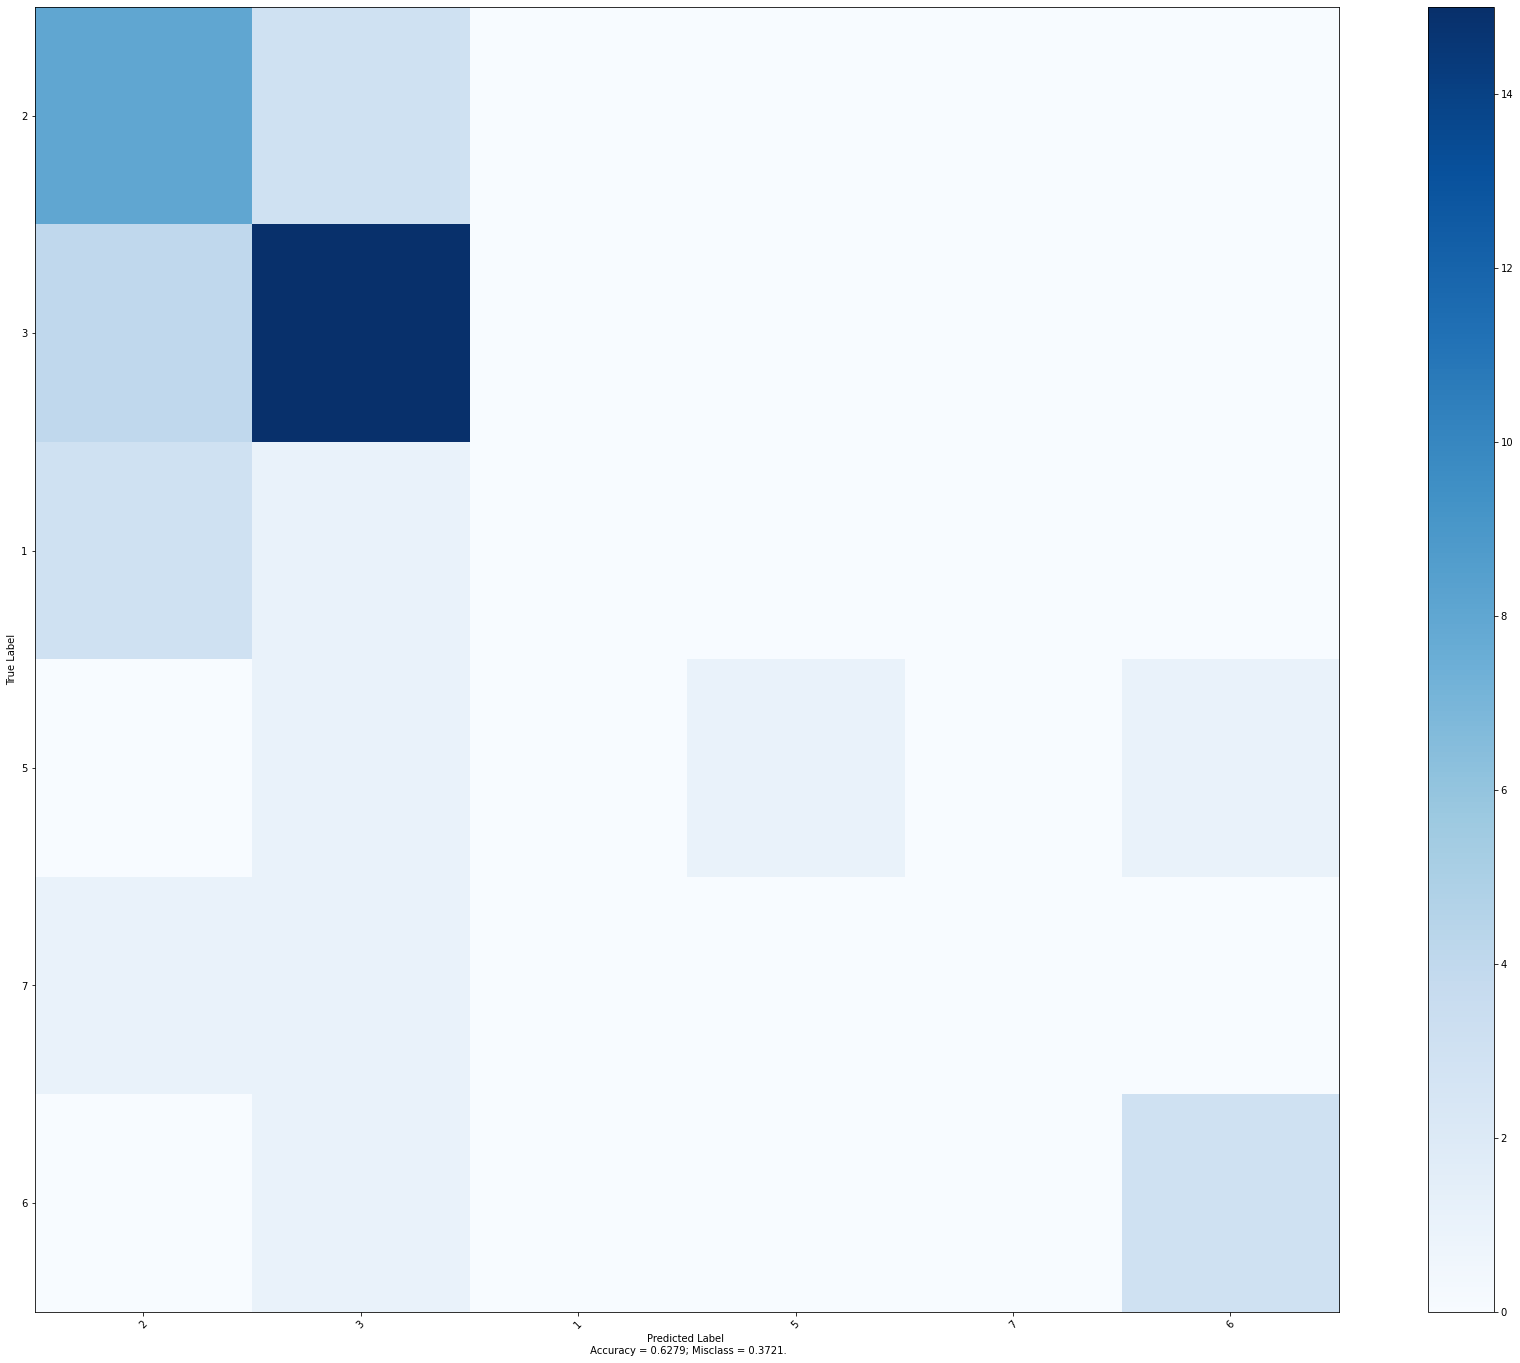

In [91]:
cm = confusion_matrix(y_test, yhat)
labels = list(y_test.unique())
labels.sort
confusionMatrixPlot(cm, labels)